# **RNN vs GRU vs LSTM Multivariate Prediction in M4 Competition**

In this Jupyter Notebook, we will try to compare the 3 famous recurrent neural network models , using a daily time-series dataset from M4 competition, which generally has an upward Trend. 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
train = pd.read_csv('Daily-train.csv')
test = pd.read_csv('Daily-test.csv')

train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9911,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920
0,D1,1017.10,1019.30,1017.00,1019.20,1018.70,1015.60,1018.50,1018.30,1018.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D2,2793.70,2793.80,2803.70,2805.80,2802.30,2795.00,2806.40,2782.20,2780.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D3,1091.30,1088.50,1085.70,1082.90,1080.10,1077.30,1074.50,1071.70,1068.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D4,1092.00,1078.00,1064.00,1050.00,1036.00,1022.00,1008.00,1092.00,1078.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D5,2938.63,2956.44,2964.41,2972.41,3014.97,3014.23,3024.08,3031.97,3062.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train.shape

(4227, 9920)

We will use the **11th** timeseries from the csv.

In [9]:
train = train.iloc[11,1:].dropna() # Get the time series we are gonna use

In [820]:
len(train)

1006

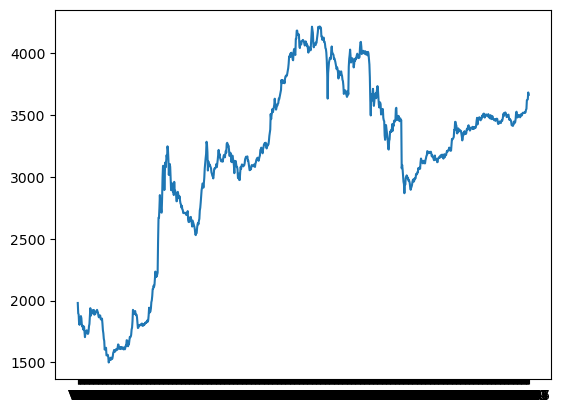

In [10]:
plt.plot(train)

We can understand that ther is an upward trend, with some major dips with in it.

In [11]:
test = test.iloc[11,1:]
test

V2     3663.3
V3     3670.6
V4     3704.1
V5     3695.2
V6     3675.7
V7     3678.5
V8     3706.6
V9     3693.7
V10    3695.1
V11    3684.8
V12    3705.9
V13    3738.1
V14    3744.2
V15    3757.4
Name: 11, dtype: object

The creator of the dataset wants us to predict the **last 14** values.

Let's check now for **autocorrellations**

/home/andreas/anaconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


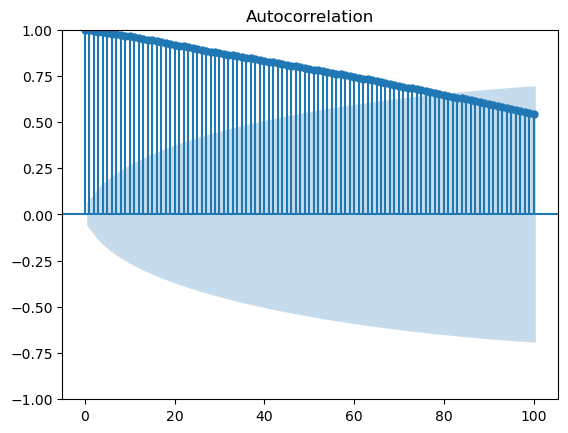

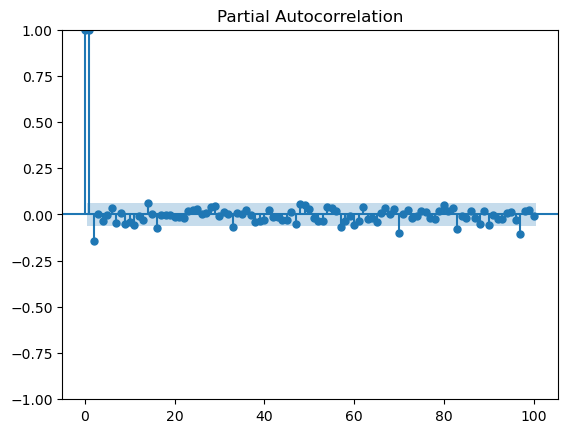

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(train,lags= 100);
plot_pacf(train, lags= 100);

At **lag = 1 & 2** there is strong direct autocorrelation

In [13]:
#Fix the indexes
new_index = pd.RangeIndex(start=0, stop=len(train))
train.index = new_index
train

0       1980.9
1       1896.1
2       1888.0
3       1812.3
4       1803.9
         ...  
1001    3621.7
1002    3624.6
1003    3627.0
1004    3683.4
1005    3664.3
Name: 11, Length: 1006, dtype: object

In [14]:
new_index = pd.RangeIndex(start=len(train), stop=len(train)+ len(test))
test.index = new_index
test

1006    3663.3
1007    3670.6
1008    3704.1
1009    3695.2
1010    3675.7
1011    3678.5
1012    3706.6
1013    3693.7
1014    3695.1
1015    3684.8
1016    3705.9
1017    3738.1
1018    3744.2
1019    3757.4
Name: 11, dtype: object

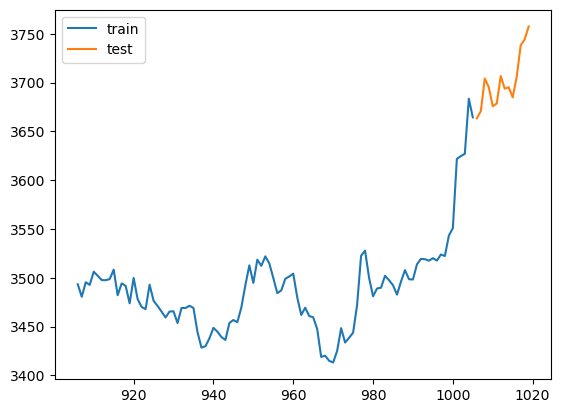

In [16]:
#Check the series on a plot
plt.plot(train[-100:],label = 'train')
plt.plot(test, label = 'test')
plt.legend()

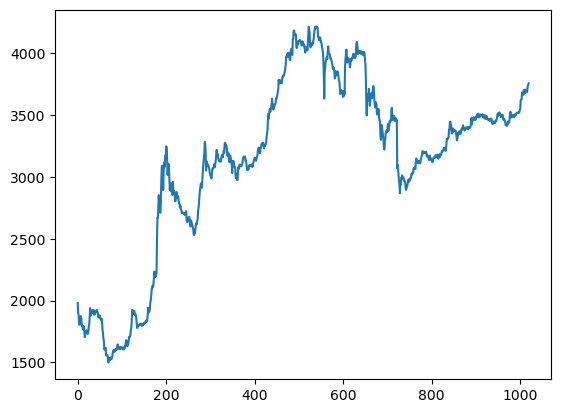

In [17]:
#Create a series which includes all of the time range
series = pd.concat([train,test])
series = series.apply(pd.to_numeric)
plt.plot(series)

# Feature Engineering

Let's create the daily returns, so we can use them in our model

In [18]:
df = pd.DataFrame(series)

df.rename(columns= { 11 : 'Values'}, inplace= True)

df

,Values
0,1980.9
1,1896.1
2,1888.0
3,1812.3
4,1803.9
...,...
1015,3684.8
1016,3705.9
1017,3738.1
1018,3744.2


In [19]:
df['Prev_Val'] = df['Values'].shift(1)

In [20]:
df['Return'] = (df['Values']- df['Prev_Val'])/df['Prev_Val']

df = df.dropna()

df.head()

,Values,Prev_Val,Return
1,1896.1,1980.9,-0.042809
2,1888.0,1896.1,-0.004272
3,1812.3,1888.0,-0.040095
4,1803.9,1812.3,-0.004635
5,1840.3,1803.9,0.020179


Now create a column named 'Up' which gets **1** if this day the value went up and **0** if it went down. This will help the model identify the movements.

In [21]:
df['Up'] = 0

for i in range(1,len(df)):
    if df.loc[i,'Return'] > 0 :
        df.loc[i,'Up'] = 1

df

/tmp/ipykernel_259222/1732819730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Up'] = 0


,Values,Prev_Val,Return,Up
1,1896.1,1980.9,-0.042809,0
2,1888.0,1896.1,-0.004272,0
3,1812.3,1888.0,-0.040095,0
4,1803.9,1812.3,-0.004635,0
5,1840.3,1803.9,0.020179,1
...,...,...,...,...
1015,3684.8,3695.1,-0.002787,0
1016,3705.9,3684.8,0.005726,1
1017,3738.1,3705.9,0.008689,1
1018,3744.2,3738.1,0.001632,1


Check now the correlation between the features. Don't forget the 'Values' column is actually the target itself.

In [841]:
df.corr()

,Values,Prev_Val,Return,Up
Values,1.000000,0.998613,-0.000406,-0.008154
Prev_Val,0.998613,1.000000,-0.051434,-0.040714
Return,-0.000406,-0.051434,1.000000,0.616383
Up,-0.008154,-0.040714,0.616383,1.000000


It seems that Prev_Val has almost **1** correlation, so we get rid of it.

In [22]:
df.drop(columns=['Prev_Val'],axis=1,inplace= True)
df

/tmp/ipykernel_259222/4109399536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Prev_Val'],axis=1,inplace= True)


,Values,Return,Up
1,1896.1,-0.042809,0
2,1888.0,-0.004272,0
3,1812.3,-0.040095,0
4,1803.9,-0.004635,0
5,1840.3,0.020179,1
...,...,...,...
1015,3684.8,-0.002787,0
1016,3705.9,0.005726,1
1017,3738.1,0.008689,1
1018,3744.2,0.001632,1


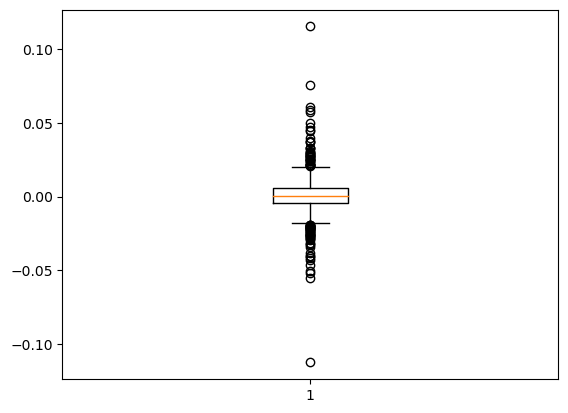

In [25]:
plt.boxplot(df['Return']);

It seems that there are a lot of outliers, in Return.

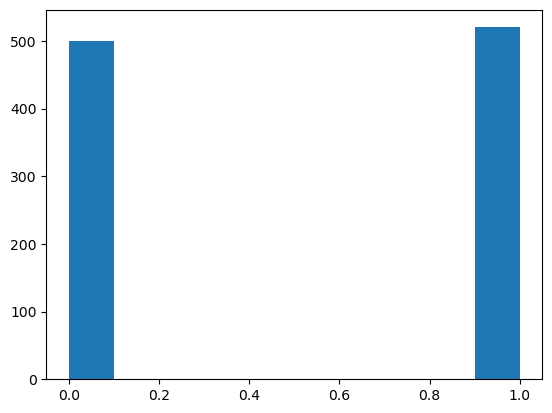

In [30]:
plt.hist(df['Up']);

Also, positive days are slightly more than the negatives. If we think about it, generally the time series tends to go upwards, so that's logical.

It is time to split the time series into time windows. After fine-tuning we decided to set the **winodow size T equal to 12**.

In [31]:
X = [] #Array with the windowed series
Y = [] #Corresponding Target of each input array
T = 12 #Size of time window
D = 3 #Number of Dimensions/Features . We Have 'Values','Return' & 'Up'
K = 1 #Number of outputs.

First,let's scale the data by fitting the StandardScaler only on the train data, so no information of the test data will pass inside the training.

In [33]:
from sklearn.preprocessing import StandardScaler
length = len(df)
scaler = StandardScaler()
scaler.fit(df[:int(length*0.75)],df[:int(length*0.75)])
df_scaled = scaler.transform(df)


In [34]:
len(df_scaled) #Number of timestamps

1019

In [35]:
df_scaled.shape

(1019, 3)

Let's now actually break the whole series into the smaller windowed series.

In [36]:
for t in range(0,len(df_scaled) - T): 
    X.append(df_scaled[t:t+T])
    Y.append(df_scaled[t+T,0]) #The target is in the first column =

N = len(X) #Number of total series sized T

X = np.array(X).reshape(N,T,D) #Make sure the input data is suitable for the RNNs
Y = np.array(Y)

X.shape,Y.shape

((1007, 12, 3), (1007,))

# Model Creation

In [37]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

After the tuning, we decided to have on the weights the l2 regularizer . We created a function to automatically create a model by giving it what recurrent architecture we want to use and how many neurons it has. 

In [38]:
def createModel(T,D,K,rnn_model,n):
    i = Input(shape = (T,D), name='input')
    if rnn_model =='GRU':
        x = GRU(n,activation='tanh',use_bias= True,recurrent_regularizer='l2',kernel_regularizer='l2',bias_regularizer='l2')(i)
    elif rnn_model =='LSTM':
        x = LSTM(n,activation='tanh',use_bias= True,recurrent_regularizer='l2',kernel_regularizer='l2',bias_regularizer='l2')(i)
    elif rnn_model=='RNN':
        x = SimpleRNN(n,activation='tanh',use_bias= True,recurrent_regularizer='l2',kernel_regularizer='l2',bias_regularizer='l2')(i)
    else:
        print('rnn_model can be "GRU","LSTM" or "RNN"')
        return(None)
    x = Dense(K,kernel_regularizer='l2',bias_regularizer='l2',activation = 'linear')(x)
    model = Model(i,x)
    model.compile(
        loss = 'mse',
        optimizer= RMSprop(learning_rate=0.0001,rho=0.999,momentum=0.95)
    )
    checkpoint = ModelCheckpoint('bestweights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
    print(model.summary())
    return model

# RNN

In [39]:
model_rnn = createModel(T,D,K,'RNN',32)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 3)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1152      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________
None


2023-07-05 13:34:56.550098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:34:56.550624: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Let's train the model for 1000 epochs to see what we get.

In [41]:
r_rnn = model_rnn.fit(
    X[:int(N*0.75)-T], Y[:int(N*0.75)-T], #We use -T so we won't have any overlap with the test data
    epochs= 1000,
    validation_data = (X[int(N*0.75):], Y[int(N*0.75):]), batch_size = 64 ,shuffle = True) 

Epoch 1/1000
12/12 [==============================] - 1s 39ms/step - loss: 0.7691 - val_loss: 0.4650
Epoch 2/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.4739 - val_loss: 0.4660
Epoch 3/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.4247 - val_loss: 0.3944
Epoch 4/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.3805 - val_loss: 0.3232
Epoch 5/1000
12/12 [==============================] - 0s 14ms/step - loss: 0.3209 - val_loss: 0.2927
Epoch 6/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.2773 - val_loss: 0.2573
Epoch 7/1000
12/12 [==============================] - 0s 19ms/step - loss: 0.2424 - val_loss: 0.2218
Epoch 8/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.2111 - val_loss: 0.1924
Epoch 9/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.1855 - val_loss: 0.1699
Epoch 10/1000
12/12 [==============================] - 0s 12ms/step - loss: 0.1638 - val_lo

Let's check the loss.

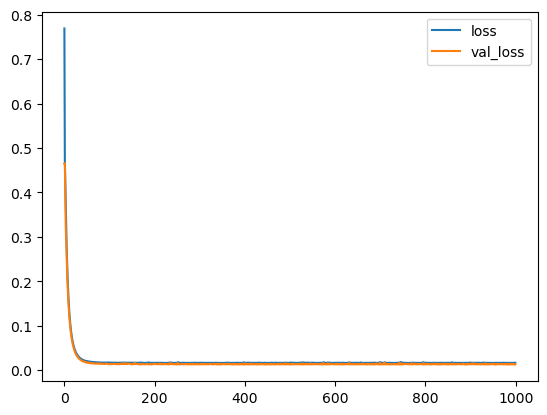

In [42]:
plt.plot(r_rnn.history['loss'], label='loss')
plt.plot(r_rnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

The loss seems to doing fine. We will continue by doing **One-Step Forecasting** to the **test data**

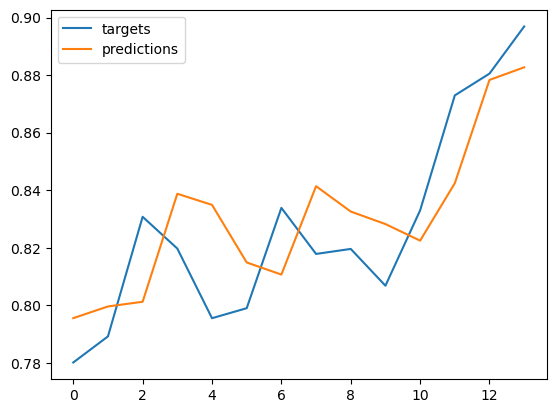

In [43]:
# One-step forecast using true targets
predictions = []
for t in range(-14,0):
    outputs = model_rnn.predict(np.expand_dims(X[t],axis = 0),verbose=0)
    predictions.append(outputs[0,0])

plt.plot(Y[-14:], label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

Let's check the **MSE** & **RMSE**:

In [44]:
from sklearn.metrics import mean_squared_error
import math
MSE = mean_squared_error(Y[-14:], predictions)
RMSE = math.sqrt(MSE)
print("Mean Square Error:\n")
print(MSE,'\n')
print("Root Mean Square Error:\n")
print(RMSE)

Mean Square Error:

0.000453897518650185 

Root Mean Square Error:

0.021304870772905077


**This not bad, but don't get tricked. This is one-step forecasting, meaning that every timestamp the model predicts 1 step to the future,by knowing the real values up to that timestamp.**

The real challenge is to check wether this model can predict multiple steps to the future. So we will proceed by applying a **Multi-Step Forecast**, giving every time as input the prediction itself to the model.

In [92]:
validation_target = Y[-14:]
validation_predictions = []
validation_predictions_returns = []
validation_predictions_up = []

# first validation input
last_x = X[-14] # 2-D array of shape (12,3)

while len(validation_predictions) < len(validation_target):
  p = model_rnn.predict(np.expand_dims(last_x,axis = 0),verbose = 0)[0,0] # 1x1 array -> scalar
  r = (p-last_x[-1,0])/last_x[-1,0]
  if r > 0:
    up = 1
  else:
    up = 0
  # update the predictions lists
  validation_predictions.append(p)
  validation_predictions_returns.append(r)
  validation_predictions_up.append(up)
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1,0] = p
  last_x[-1,1] = r
  last_x[-1,2] = up

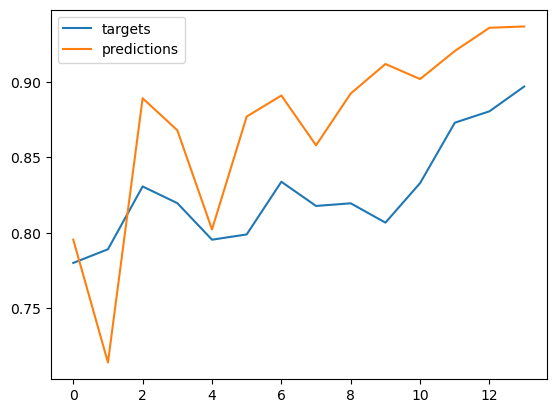

In [46]:
plt.plot(Y[-14:], label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()

In [47]:
MSE_rnn = mean_squared_error(Y[-14:], validation_predictions)
RMSE_rnn = math.sqrt(MSE_rnn)
print("Mean Square Error:\n")
print(MSE_rnn,'\n')
print("Root Mean Square Error:\n")
print(RMSE_rnn)

Mean Square Error:

0.003610739842014861 

Root Mean Square Error:

0.060089432032719874


So the result are pleasant. We can see that we have a pretty good MSE & RMSE, and the plot shows that model understands the pattern that is going to come for the next 14 days , but it losses a bit on the actual values. Let's now take 8 other random 14-length series from the test data we didn't use for training, to check if the model actually does it good on the other timestamps too.

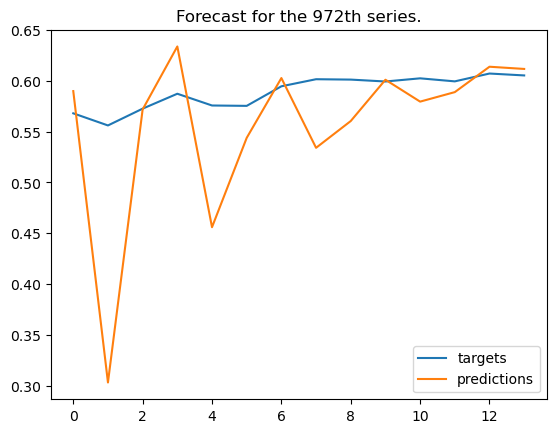

Mean Square Error:  0.0063359178180147765
Root Mean Square Error:  0.07959847874183763


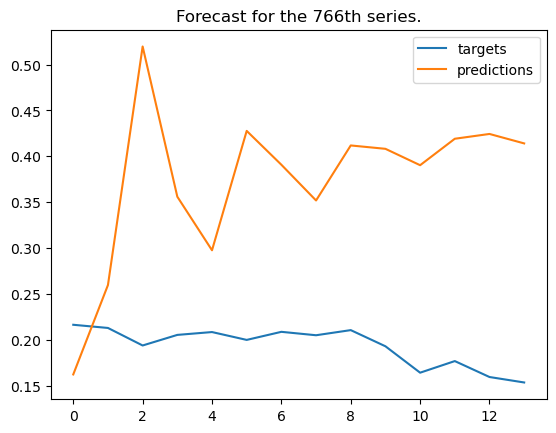

Mean Square Error:  0.04170874429116108
Root Mean Square Error:  0.20422718793334318


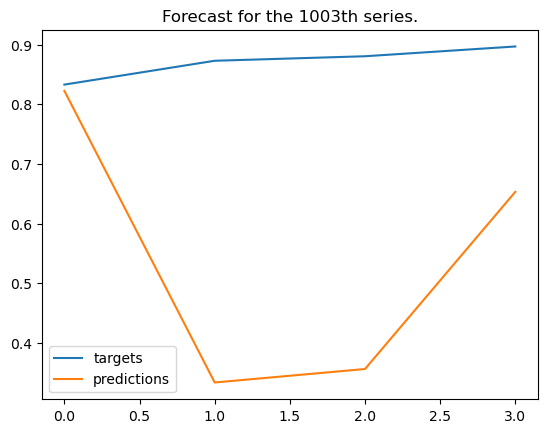

Mean Square Error:  0.1563287090757077
Root Mean Square Error:  0.3953842549668711


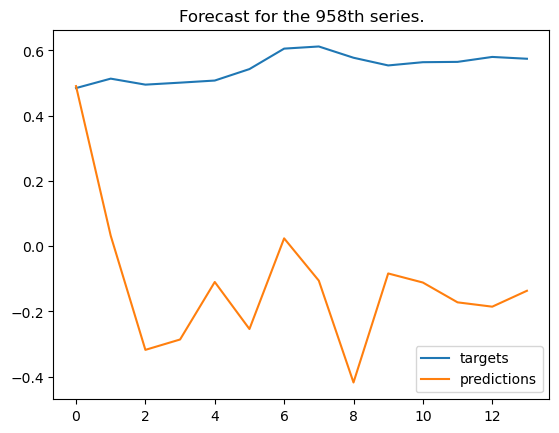

Mean Square Error:  0.4902918674768762
Root Mean Square Error:  0.7002084457337516


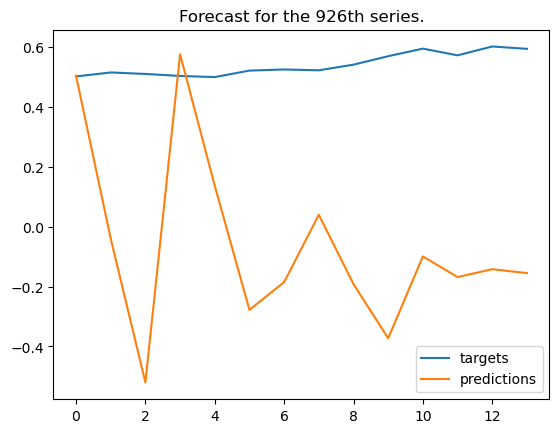

Mean Square Error:  0.45929635010009945
Root Mean Square Error:  0.6777140621973986


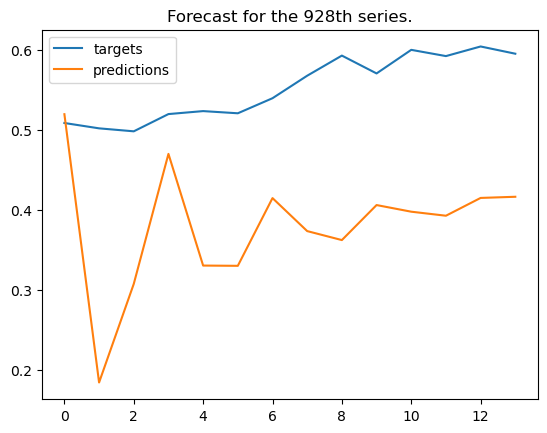

Mean Square Error:  0.03552834163592329
Root Mean Square Error:  0.18848963270143876


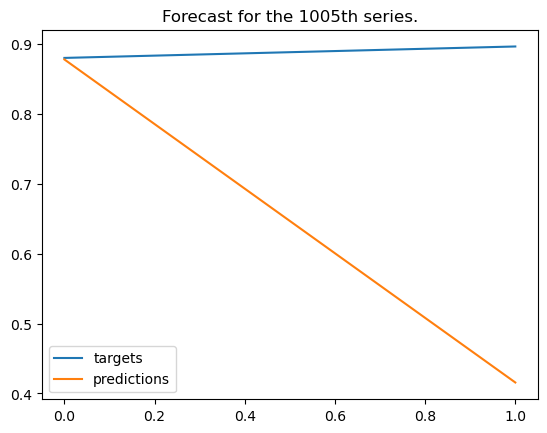

Mean Square Error:  0.1157830116337145
Root Mean Square Error:  0.34026902831982003


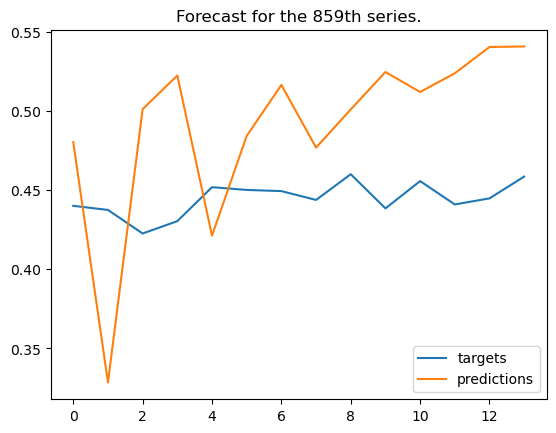

Mean Square Error:  0.005069948171981587
Root Mean Square Error:  0.07120356853403899


In [49]:
for _ in range(8):
    idx = np.random.randint(int(N*0.75),N)
    validation_target = Y[idx:idx+14] #Random Test Data of size 14 
    validation_preds = []
    validation_preds_returns = []
    validation_preds_up = []
    # First validation input
    last_x = X[idx]

    while len(validation_preds) < len(validation_target):
        p = model_rnn.predict(np.expand_dims(last_x,axis = 0),verbose=0)[0,0] # 1x1 array -> scalar

        # Update the predictions list
        r = (p-last_x[-1,0])/last_x[-1,0]
        if r > 0:
            up = 1
        else:
            up = 0
        # Make the new input
        validation_preds.append(p)
        validation_preds_returns.append(r)
        validation_preds_up.append(up)
        last_x = np.roll(last_x, -1)
        last_x[-1,0] = p
        last_x[-1,1] = r
        last_x[-1,2] = up
    # Print the validation predictions and target
    plt.plot(validation_target, label='targets')
    plt.plot(validation_preds, label='predictions')
    plt.title(f'Forecast for the {idx}th series.')
    plt.legend()
    plt.show()
    MSE = mean_squared_error(validation_target, validation_preds)
    RMSE = math.sqrt(MSE)
    print("Mean Square Error: ", MSE)
    print("Root Mean Square Error: ",RMSE)

Most of the time the **1st prediction is really close to the actual value**, but then model doesn't do well. 

We can say that **the model is pretty good when it comes to predicting 1 step to the future**.

Let's now see in real values , how well did the model do on the test data.

In [93]:
df_preds = pd.DataFrame({
    'Values' : validation_predictions,
    'Returns': validation_predictions_returns,
    'Up': validation_predictions_up
})

df_preds

,Values,Returns,Up
0,0.795504,0.018126,1
1,0.714201,-0.102204,0
2,0.889147,0.244954,1
3,0.867923,-0.023871,0
4,0.802280,-0.075632,0
5,0.877007,0.093143,1
6,0.890934,0.015880,1
7,0.857964,-0.037007,0
8,0.892275,0.039992,1
9,0.911811,0.021894,1


In [94]:
inv_pred = scaler.inverse_transform(df_preds)

In [95]:
inv = pd.DataFrame(inv_pred,columns=['Values','Returns','Up'])
new_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test))
inv.index = new_index


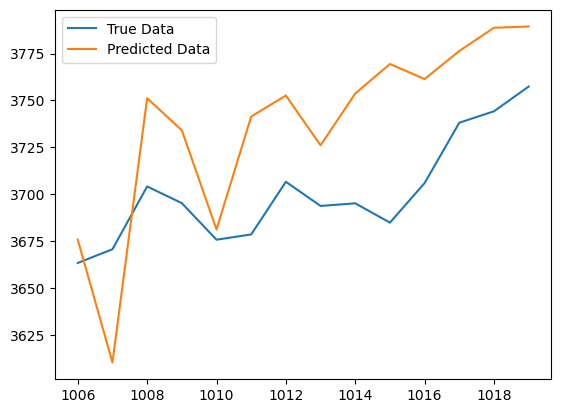

In [96]:
plt.plot(test,label = 'True Data')
plt.plot(inv.iloc[:,0], label = 'Predicted Data')
plt.legend()

In [54]:
from sklearn.metrics import mean_squared_error
import math
MSE_rnn = mean_squared_error(test, inv.iloc[:,0])
RMSE_rnn = math.sqrt(MSE_rnn)
print("Mean Square Error:\n")
print(MSE_rnn,'\n')
print("Root Mean Square Error:\n")
print(RMSE_rnn)

Mean Square Error:

2343.9794177054214 

Root Mean Square Error:

48.414661185486175


Sto we get a **RMSE = 48.41** which is a very good score, if we assume that the values are arround **3700**

# GRU

We will now apply the same model with the only difference that the models uses GRU instead of SimpleRNN.

In [55]:
model_gru = createModel(T,D,K,'GRU',32)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 3)]           0         
                                                                 
 gru (GRU)                   (None, 32)                3552      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
r_gru = model_gru.fit(
    X[:int(N*0.75)-T], Y[:int(N*0.75)-T],
    epochs= 1000,
    validation_data = (X[int(N*0.75):], Y[int(N*0.75):]), batch_size = 64,shuffle = True) 

Epoch 1/1000


12/12 [==============================] - 2s 66ms/step - loss: 0.8840 - val_loss: 0.5345
Epoch 2/1000
12/12 [==============================] - 0s 18ms/step - loss: 0.4089 - val_loss: 0.2661
Epoch 3/1000
12/12 [==============================] - 0s 27ms/step - loss: 0.2812 - val_loss: 0.2321
Epoch 4/1000
12/12 [==============================] - 0s 23ms/step - loss: 0.2511 - val_loss: 0.2049
Epoch 5/1000
12/12 [==============================] - 0s 17ms/step - loss: 0.2001 - val_loss: 0.1650
Epoch 6/1000
12/12 [==============================] - 0s 22ms/step - loss: 0.1565 - val_loss: 0.1235
Epoch 7/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.1164 - val_loss: 0.0946
Epoch 8/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0888 - val_loss: 0.0741
Epoch 9/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.0710 - val_loss: 0.0590
Epoch 10/1000
12/12 [==============================] - 0s 23ms/step - loss: 0.0573 - val_loss: 0.0490
Ep

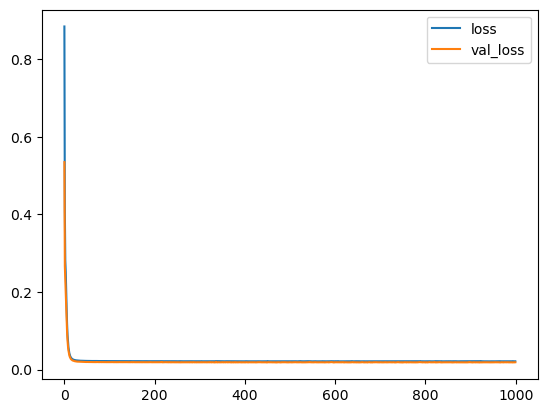

In [57]:
plt.plot(r_gru.history['loss'], label='loss')
plt.plot(r_gru.history['val_loss'], label='val_loss')
plt.legend()

Good training, probably no overfitting or underfitting.

Proceed with the One-Step Forecast.

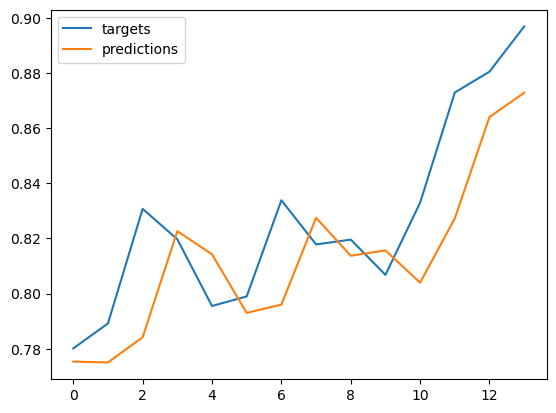

In [59]:
# One-step forecast using true targets
predictions_gru = []
for t in range(-14,0):
    outputs = model_gru.predict(np.expand_dims(X[t],axis = 0),verbose=0)
    predictions_gru.append(outputs[0,0])

plt.plot(Y[-14:], label='targets')
plt.plot(predictions_gru, label='predictions')
plt.legend()
plt.show()

It seems that it is really close at some timestamps (for example t = 3) . Let's check how it is doing when predicting the whole test data at once with **Multistep Forecasting**.

In [60]:
validation_target = Y[-14:]
validation_predictions = []
validation_predictions_returns = []
validation_predictions_up = []

# first validation input
last_x = X[-14] # 2-D array of shape (12,3)

while len(validation_predictions) < len(validation_target):
  p = model_gru.predict(np.expand_dims(last_x,axis = 0),verbose = 0)[0,0] # 1x1 array -> scalar
  r = (p-last_x[-1,0])/last_x[-1,0]
  if r > 0:
    up = 1
  else:
    up = 0
  # update the predictions lists
  validation_predictions.append(p)
  validation_predictions_returns.append(r)
  validation_predictions_up.append(up)
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1,0] = p
  last_x[-1,1] = r
  last_x[-1,2] = up

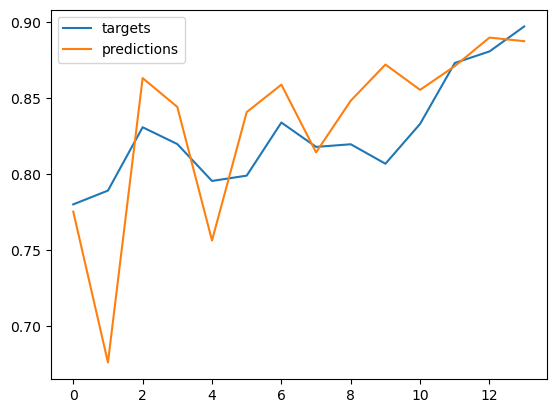

In [61]:
plt.plot(Y[-14:], label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()

In [63]:
MSE = mean_squared_error(validation_target, validation_preds)
RMSE = math.sqrt(MSE)
print("Mean Square Error: ", MSE)
print("Root Mean Square Error: ",RMSE)

Mean Square Error:  0.11447773514957349
Root Mean Square Error:  0.3383455853850815


We get a **RMSE = 0.33** which is decent. We can see that some of the values are predicted with a high accuracy, and some not. Let's do the plot with the random 8 series to check how is it doing in more data.

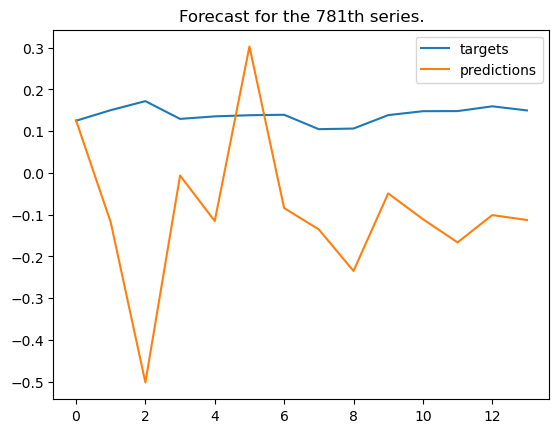

Mean Square Error:  0.08543998286911134
Root Mean Square Error:  0.29230118519963505


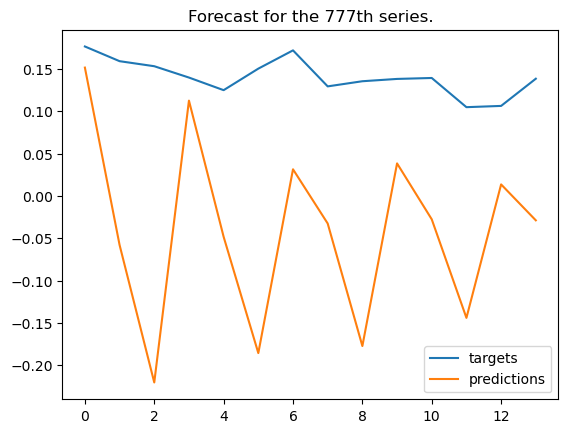

Mean Square Error:  0.04370560115409706
Root Mean Square Error:  0.20905884615126205


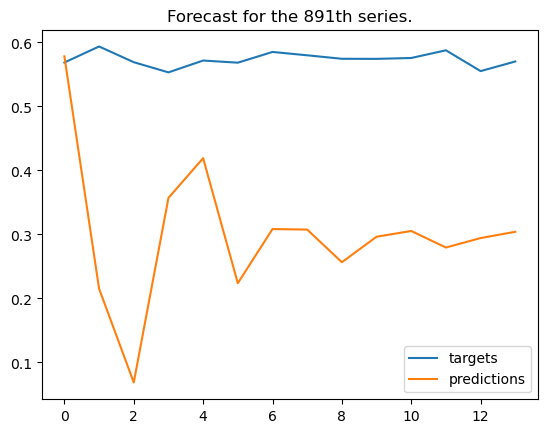

Mean Square Error:  0.08646552302081924
Root Mean Square Error:  0.29405020493245576


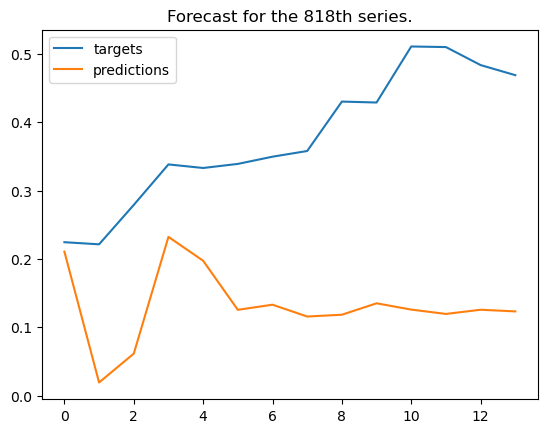

Mean Square Error:  0.0713612781266432
Root Mean Square Error:  0.2671353180068918


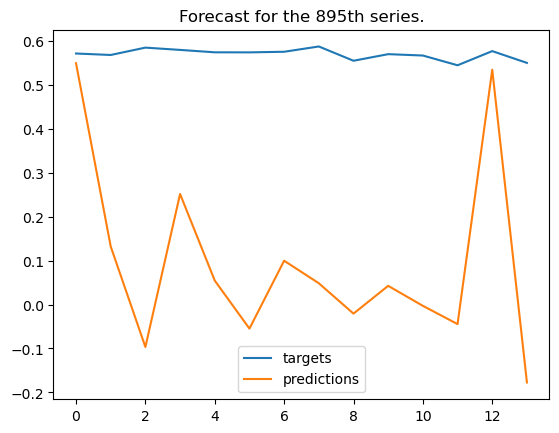

Mean Square Error:  0.2685547107448439
Root Mean Square Error:  0.5182226459204999


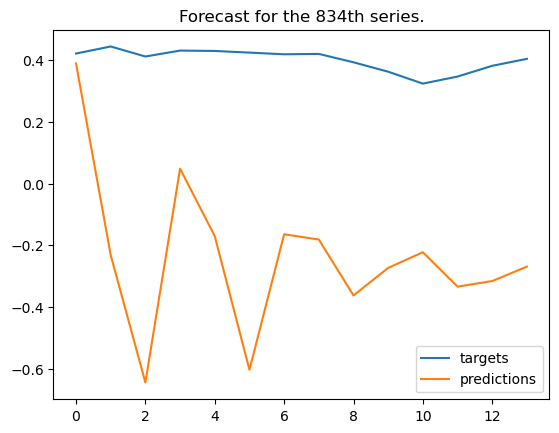

Mean Square Error:  0.46561445544664276
Root Mean Square Error:  0.6823594767031838


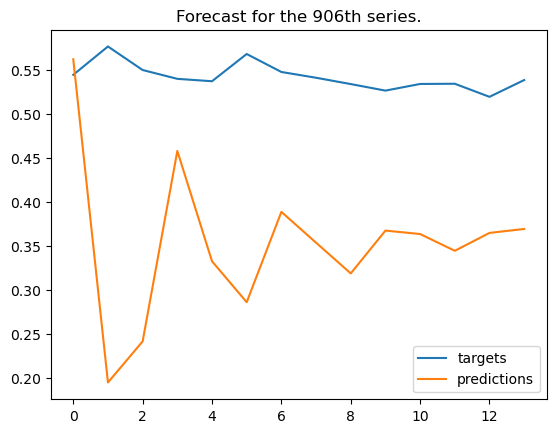

Mean Square Error:  0.04440811194389815
Root Mean Square Error:  0.21073232296896968


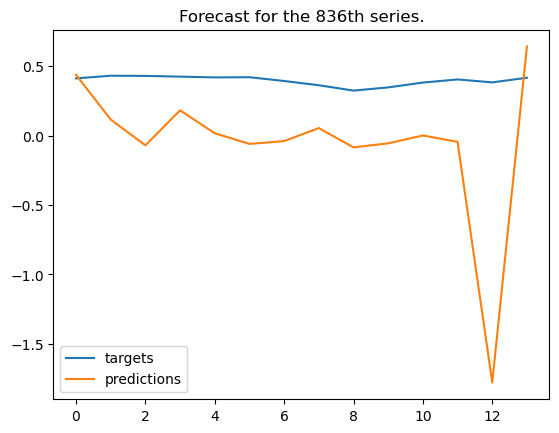

Mean Square Error:  0.4633864915187389
Root Mean Square Error:  0.6807249749485756


In [64]:
for _ in range(8):
    idx = np.random.randint(int(N*0.75),N)
    validation_target = Y[idx:idx+14] #Random Test Data of size 14 
    validation_preds = []
    validation_preds_returns = []
    validation_preds_up = []
    # First validation input
    last_x = X[idx]

    while len(validation_preds) < len(validation_target):
        p = model_gru.predict(np.expand_dims(last_x,axis = 0),verbose=0)[0,0] # 1x1 array -> scalar

        # Update the predictions list
        r = (p-last_x[-1,0])/last_x[-1,0]
        if r > 0:
            up = 1
        else:
            up = 0
        # Make the new input
        validation_preds.append(p)
        validation_preds_returns.append(r)
        validation_preds_up.append(up)
        last_x = np.roll(last_x, -1)
        last_x[-1,0] = p
        last_x[-1,1] = r
        last_x[-1,2] = up
    # Print the validation predictions and target
    plt.plot(validation_target, label='targets')
    plt.plot(validation_preds, label='predictions')
    plt.title(f'Forecast for the {idx}th series.')
    plt.legend()
    plt.show()
    MSE = mean_squared_error(validation_target, validation_preds)
    RMSE = math.sqrt(MSE)
    print("Mean Square Error: ", MSE)
    print("Root Mean Square Error: ",RMSE)

We can see that it is always starting losing it after the second timestamp, which is not very good. The great thing is that the model seems to be pretty **accurate when it comes to predicting the 1st unknown value!**

Let's proceed by checking the real values of the multistep prediction of the test data (as given by M4 Competition).

In [65]:
df_preds = pd.DataFrame({
    'Values' : validation_predictions,
    'Returns': validation_predictions_returns,
    'Up': validation_predictions_up
})

df_preds

,Values,Returns,Up
0,0.775320,-0.007707,0
1,0.676311,-0.127701,0
2,0.863029,0.276083,1
3,0.844077,-0.021960,0
4,0.756387,-0.103889,0
5,0.840660,0.111415,1
6,0.858702,0.021462,1
7,0.814270,-0.051743,0
8,0.848162,0.041622,1
9,0.871886,0.027972,1


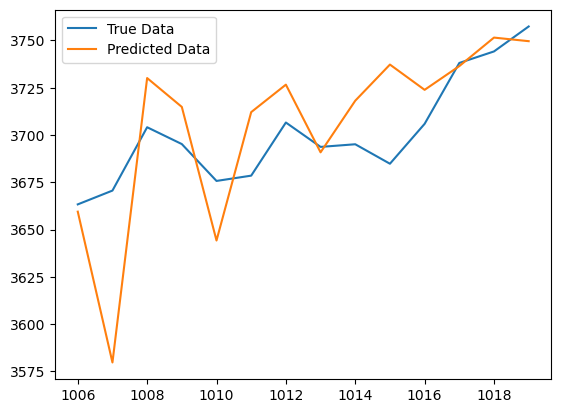

In [68]:
inv_pred = scaler.inverse_transform(df_preds)
inv_gru = pd.DataFrame(inv_pred,columns=['Values','Returns','Up'])
new_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test))
inv_gru.index = new_index
plt.plot(test,label = 'True Data')
plt.plot(inv_gru.iloc[:,0], label = 'Predicted Data')
plt.legend()
plt.show();

In [69]:
MSE_gru = mean_squared_error(test, inv_gru.iloc[:,0])
RMSE_gru = math.sqrt(MSE_gru)
print("Mean Square Error:\n")
print(MSE_gru,'\n')
print("Root Mean Square Error:\n")
print(RMSE_gru)

Mean Square Error:

1114.1277336801918 

Root Mean Square Error:

33.378552000951025


In real values, we have **RMSE = 33.37** which is a satisfying score.

# LSTM 

Let's now check how LSTM is doing on this dataset, with the exactly same hyperparameters.

In [70]:
model_lstm = createModel(T,D,K,'LSTM',32)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
None


And fit it too, for 1000 epochs.

In [71]:
r_lstm = model_lstm.fit(
    X[:int(N*0.75)-T], Y[:int(N*0.75)-T],
    epochs= 1000,
    validation_data = (X[int(N*0.75):], Y[int(N*0.75):]), batch_size = 64,shuffle = True) 

Epoch 1/1000


12/12 [==============================] - 2s 60ms/step - loss: 1.0553 - val_loss: 0.7158
Epoch 2/1000
12/12 [==============================] - 0s 21ms/step - loss: 0.5873 - val_loss: 0.4306
Epoch 3/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.4433 - val_loss: 0.4135
Epoch 4/1000
12/12 [==============================] - 0s 27ms/step - loss: 0.3759 - val_loss: 0.3231
Epoch 5/1000
12/12 [==============================] - 0s 21ms/step - loss: 0.3111 - val_loss: 0.2550
Epoch 6/1000
12/12 [==============================] - 0s 24ms/step - loss: 0.2367 - val_loss: 0.2062
Epoch 7/1000
12/12 [==============================] - 0s 20ms/step - loss: 0.1865 - val_loss: 0.1639
Epoch 8/1000
12/12 [==============================] - 0s 25ms/step - loss: 0.1496 - val_loss: 0.1270
Epoch 9/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.1245 - val_loss: 0.1112
Epoch 10/1000
12/12 [==============================] - 0s 23ms/step - loss: 0.1058 - val_loss: 0.0970
Ep

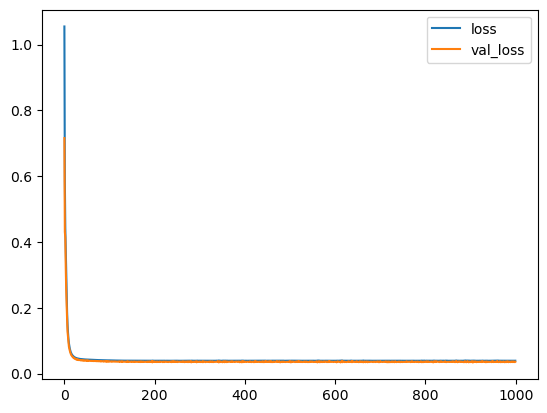

In [73]:
plt.plot(r_lstm.history['loss'], label='loss')
plt.plot(r_lstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

Training was good. Let's proceed with one step forcasting.

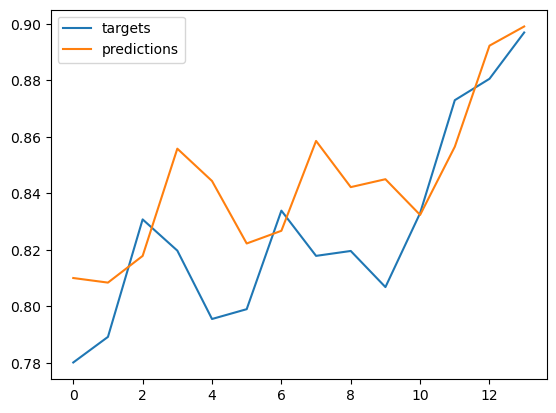

In [74]:
# One-step forecast using true targets
predictions_lstm = []
for t in range(-14,0):
    outputs = model_lstm.predict(np.expand_dims(X[t],axis = 0),verbose=0)
    predictions_lstm.append(outputs[0,0])

plt.plot(Y[-14:], label='targets')
plt.plot(predictions_lstm, label='predictions')
plt.legend()
plt.show()

We can see some values are close (e.g. t = 10) and some not (e.g. t = 4). Let's continue with **Multi Step Forecasting**.

In [76]:
validation_target = Y[-14:]
validation_predictions = []
validation_predictions_returns = []
validation_predictions_up = []

# first validation input
last_x = X[-14] # 2-D array of shape (12,3)

while len(validation_predictions) < len(validation_target):
  p = model_lstm.predict(np.expand_dims(last_x,axis = 0),verbose = 0)[0,0] # 1x1 array -> scalar
  r = (p-last_x[-1,0])/last_x[-1,0]
  if r > 0:
    up = 1
  else:
    up = 0
  # update the predictions lists
  validation_predictions.append(p)
  validation_predictions_returns.append(r)
  validation_predictions_up.append(up)
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1,0] = p
  last_x[-1,1] = r
  last_x[-1,2] = up

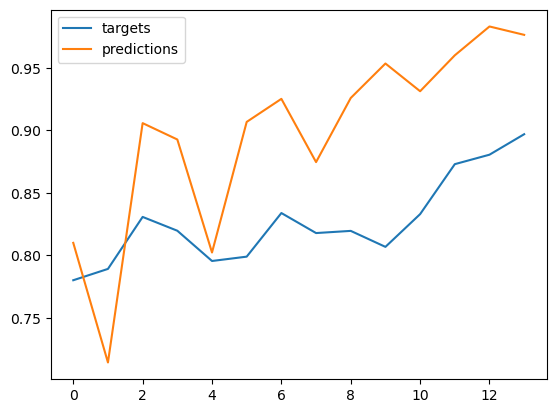

In [77]:
plt.plot(Y[-14:], label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()


In [79]:
MSE = mean_squared_error(validation_target, validation_predictions)
RMSE = math.sqrt(MSE)
print("Mean Square Error: ", MSE)
print("Root Mean Square Error: ",RMSE)

Mean Square Error:  0.007681834180641717
Root Mean Square Error:  0.08764607338975157


The first prediction is close. After that it starts loosing it. **RMSE = 0.88** which is not that good. Let's try that method on other random test data.

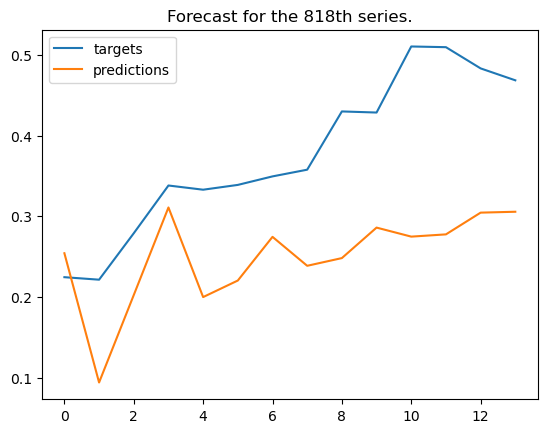

Mean Square Error:  0.021200658221357256
Root Mean Square Error:  0.14560445810948666


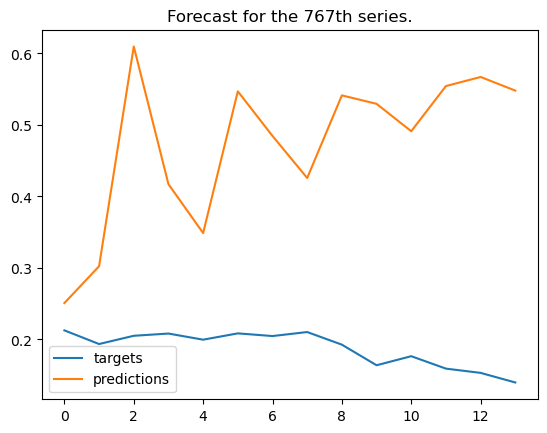

Mean Square Error:  0.09494587014446754
Root Mean Square Error:  0.30813287741568174


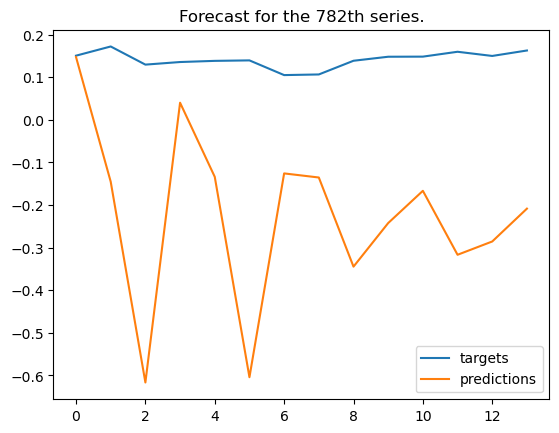

Mean Square Error:  0.17456227483156453
Root Mean Square Error:  0.4178065040560816


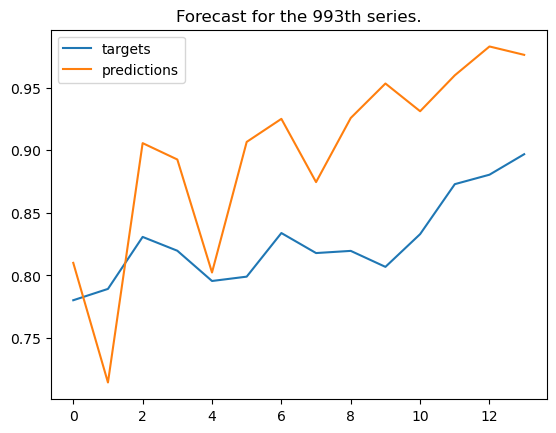

Mean Square Error:  0.007681834180641717
Root Mean Square Error:  0.08764607338975157


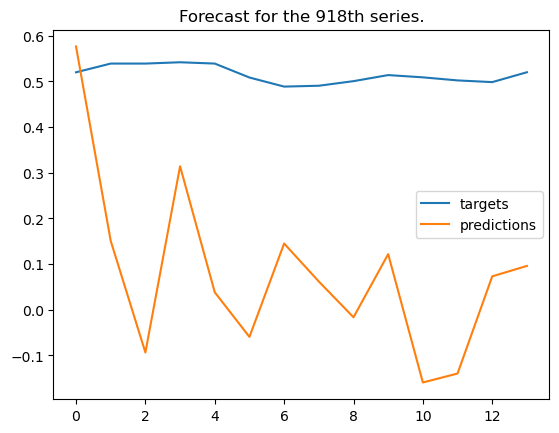

Mean Square Error:  0.22279444450713776
Root Mean Square Error:  0.4720110639668712


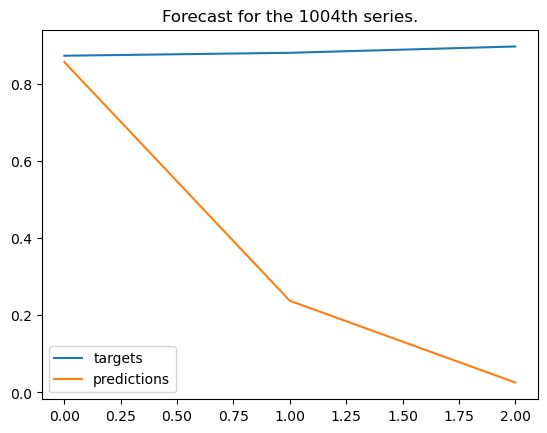

Mean Square Error:  0.39071467561870116
Root Mean Square Error:  0.6250717363780746


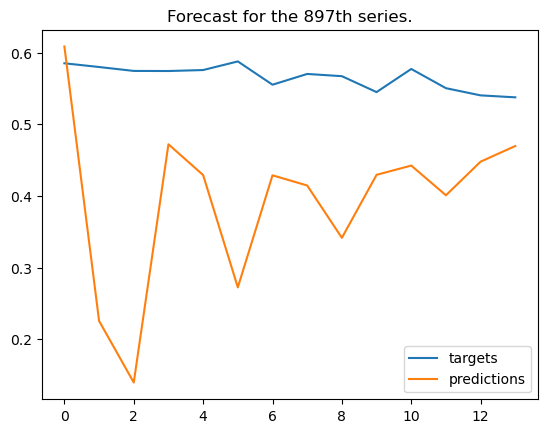

Mean Square Error:  0.04321174896852868
Root Mean Square Error:  0.20787435861242887


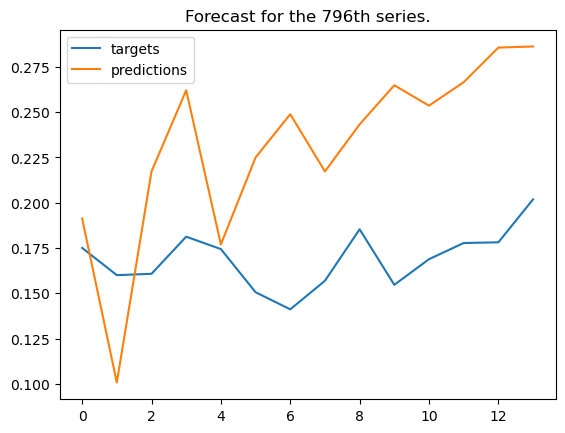

Mean Square Error:  0.0059645575582091565
Root Mean Square Error:  0.07723054808952969


In [80]:
for _ in range(8):
    idx = np.random.randint(int(N*0.75),N)
    validation_target = Y[idx:idx+14] #Random Test Data of size 14 
    validation_preds = []
    validation_preds_returns = []
    validation_preds_up = []
    # First validation input
    last_x = X[idx]

    while len(validation_preds) < len(validation_target):
        p = model_lstm.predict(np.expand_dims(last_x,axis = 0),verbose=0)[0,0] # 1x1 array -> scalar

        # Update the predictions list
        r = (p-last_x[-1,0])/last_x[-1,0]
        if r > 0:
            up = 1
        else:
            up = 0
        # Make the new input
        validation_preds.append(p)
        validation_preds_returns.append(r)
        validation_preds_up.append(up)
        last_x = np.roll(last_x, -1)
        last_x[-1,0] = p
        last_x[-1,1] = r
        last_x[-1,2] = up
    # Print the validation predictions and target
    plt.plot(validation_target, label='targets')
    plt.plot(validation_preds, label='predictions')
    plt.title(f'Forecast for the {idx}th series.')
    plt.legend()
    plt.show()
    MSE = mean_squared_error(validation_target, validation_preds)
    RMSE = math.sqrt(MSE)
    print("Mean Square Error: ", MSE)
    print("Root Mean Square Error: ",RMSE)

In the most of them, the model predicts close values only for the first unknown value and then losses it. Also most of the time **RMSE is pretty big.** Let's now check the real values for the test data (last 14 values of the data).

In [81]:
df_preds = pd.DataFrame({
    'Values' : validation_predictions,
    'Returns': validation_predictions_returns,
    'Up': validation_predictions_up
})

df_preds

,Values,Returns,Up
0,0.809992,0.036669,1
1,0.714320,-0.118116,0
2,0.905754,0.267995,1
3,0.892664,-0.014451,0
4,0.802281,-0.101251,0
5,0.906731,0.130190,1
6,0.925171,0.020337,1
7,0.874579,-0.054684,0
8,0.925869,0.058645,1
9,0.953438,0.029777,1


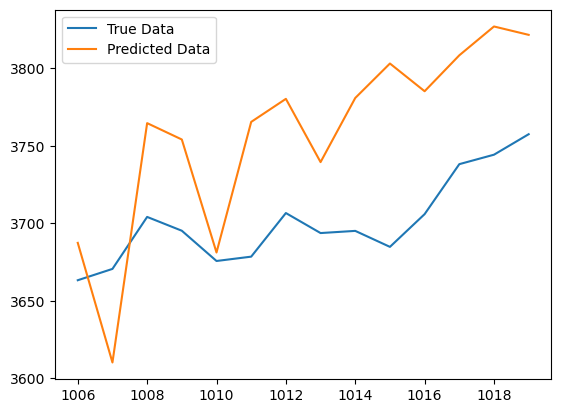

In [82]:
inv_pred = scaler.inverse_transform(df_preds)
inv_lstm = pd.DataFrame(inv_pred,columns=['Values','Returns','Up'])
new_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test))
inv_lstm.index = new_index
plt.plot(test,label = 'True Data')
plt.plot(inv_lstm.iloc[:,0], label = 'Predicted Data')
plt.legend()
plt.show();

In [83]:
MSE_lstm = mean_squared_error(test, inv_lstm.iloc[:,0])
RMSE_lstm = math.sqrt(MSE_lstm)
print("Mean Square Error:\n")
print(MSE_lstm,'\n')
print("Root Mean Square Error:\n")
print(RMSE_lstm)

Mean Square Error:

4986.806581889445 

Root Mean Square Error:

70.617324941472


**RMSE in real values is 70.61 which is not that big**.

# Comparison

Let's now try to compare the 3 model. We will start by comparing the validation losses.

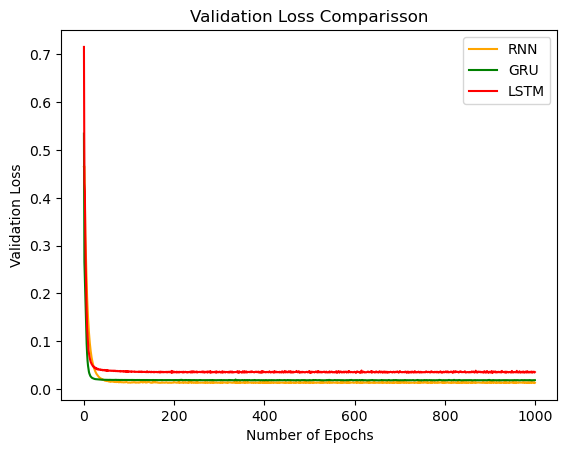

In [90]:
plt.plot(r_rnn.history['val_loss'], label='RNN', color = 'orange')
plt.plot(r_gru.history['val_loss'], label='GRU', color = 'green')
plt.plot(r_lstm.history['val_loss'], label='LSTM', color = 'red')
plt.title('Validation Loss Comparisson')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show();

We can see that **RNN has the lower validation loss**, **LSTM had the higher** and **GRU actually reached its minimum loss faster than the other 2**.

Let's now compare the prediction of the last 14 values of the series.

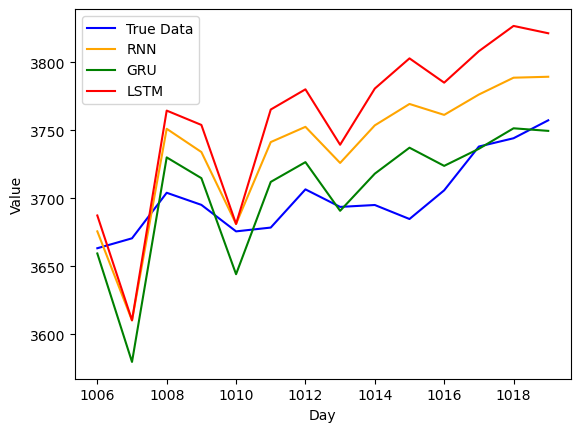

In [99]:
plt.plot(test,label = 'True Data', color = 'blue')
plt.plot(inv.iloc[:,0], label = 'RNN',color = 'orange')
plt.plot(inv_gru.iloc[:,0], label = 'GRU',color = 'green')
plt.plot(inv_lstm.iloc[:,0], label = 'LSTM',color = 'red')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show();

In [98]:
print("RNN's RMSE: ",RMSE_rnn)
print("GRU's RMSE: ",RMSE_gru)
print("LSTM's RMSE: ",RMSE_lstm)

RNN's RMSE:  48.414661185486175
GRU's RMSE:  33.378552000951025
LSTM's RMSE:  70.617324941472


We can see that GRU managed to have lower RMSE than the other 2. We can see that the pattern the 3 models predict is pretty much the same. The difference is that GRU always predicts lower prices than the other 2, or we could infromally say that if we fitted a line from the first to the last point of every linechart, the "slope" of GRU's line is the closest to the "slope" of the True Data line.